In [59]:
import matplotlib.pyplot as plt 
import torch
import numpy as np 
from tqdm import tqdm

dtype = torch.float32

device = "cuda"

In [7]:
x = 0.1*(torch.rand((L,width),dtype=dtype,device=device) - 1)
v = torch.zeros((L,width),dtype=dtype,device=device)
t = torch.zeros(width,dtype=dtype,device=device)



steps = 100 
eventsSizes = torch.empty((0),dtype=dtype,device = device)
xdata = torch.zeros((steps,L,width),dtype=dtype,device = device)
vdata = torch.zeros((steps,L,width),dtype=dtype,device = device)
tdata = torch.zeros((steps,width),dtype=dtype,device = device)



for i in range(steps):
    x,v,t = step(x,v,t)
    xdata[i] = x
    vdata[i] = v
    tdata[i] = t 

slipping = (vdata>0).any(dim=1)

slippingR = slipping.roll(+1,dims = 0)
slippingL = slipping.roll(-1,dims = 0)
slippingR[0] = False
slippingL[-1] = False 

ends  = torch.logical_xor( slipping ,(slipping *slippingL))
starts  = torch.logical_xor( slipping ,(slipping *slippingR))

totalX = xdata.sum(1)

eventsSize = totalX.T[ends.T] - totalX.T[starts.T]  

eventsSteps = (torch.argwhere(ends.T)  - torch.argwhere(starts.T))[:,1]

eventsTimes = tdata.T[ends.T] - tdata.T[starts.T] 

torch.Size([4871])

In [ ]:
ends.T

In [32]:
L = 4000
u = 0.01
alpha = 3
k1 = 1
k2 = 0.04
eps = 0.01

F0 = 1
m = 1
h = 0.1 
width = 100




# L = 50
# u = 0.01
# alpha = 0.1
# k1 = 1
# k2 = 0.01
# eps = 0.01  
# F0 = 1
# m = 1
# h = 0.1

# def f(x,v,t):
#     xIntoLeft = torch.roll(x,-1,dims=0)
#     xIntoRight = torch.roll(x,1,dims=0)

#     xIntoLeft[-1,:] = 0
#     xIntoRight[0,:] = 0



#     return torch.where(v==0,
#     torch.where(torch.abs(-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t) < F0, -x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t ,F0*(1-eps) ),
#     F0*(1-eps)/(1+alpha*torch.abs(v)))


def f(x,v,t):
    xIntoLeft = torch.roll(x,-1,dims=0)
    xIntoRight = torch.roll(x,1,dims=0)

    xIntoLeft[-1,:] = 0
    xIntoRight[0,:] = 0



    return torch.where(v==0,
    torch.where(torch.abs(-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t) < F0, -x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t ,F0*(1-eps) ),
    F0*(1-eps)/(1+alpha*torch.abs(v)/(1-eps)))


def acc(x,v,t):
    xIntoLeft = torch.roll(x,-1,dims=0)
    xIntoRight = torch.roll(x,1,dims=0)

    xIntoLeft[-1,:] = 0
    xIntoRight[0,:] = 0

    return (-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t - f(x,v,t) )/m


def tenstion(x,v,t):
    return m*acc(x,v,t) + f(x,v,t)


def step(x,v,t):
    t = torch.where((v ==0).all( 0),t + (F0-tenstion(x,v,t).max(0)[0])/(k2*u) , t) 
 

    k_1 = v
    l_1 = acc(x,v,t)

    k_2 = v + l_1*h/2
    l_2 = acc(x+k_1*h/2,v + l_1*h/2,t + h/2)

    k_3 = v + l_2*h/2
    l_3 = acc(x+k_2*h/2,v + l_2*h/2,t + h/2)

    k_4 = v + l_3/2
    l_4 = acc(x+k_3*h,v + l_3*h, t + h)

    deltax = (k_1 + 2*k_2 + 2*k_3 + k_4)*h/6

    x = x +  deltax
    
    # x = x + torch.where(deltax >  0, deltax , 0  ) 
    v = v +  (l_1 + 2*l_2 + 2*l_3 + l_4)*h/6
    
    v = torch.where(v<0, 0, v)
    return x, v,t+h

def run(x,v,t,steps):
    xdata = torch.zeros((steps,L,width),dtype=dtype,device = device)
    vdata = torch.zeros((steps,L,width),dtype=dtype,device = device)
    tdata = torch.zeros((steps,width),dtype=dtype,device = device)
    for i in range(steps):
        x,v,t = step(x,v,t)
        xdata[i] = x
        vdata[i] = v

    slipping = (vdata>0).any(dim=1)

    slippingR = slipping.roll(+1,dims = 0)
    slippingL = slipping.roll(-1,dims = 0)
    slippingR[0] = False
    slippingL[-1] = False 

    ends  = torch.logical_xor( slipping ,(slipping *slippingL))
    starts  = torch.logical_xor( slipping ,(slipping *slippingR))

    totalX = xdata.sum(1)

    eventsSize = totalX.T[ends.T] - totalX.T[starts.T]  

    eventsStep = (torch.argwhere(ends.T)  - torch.argwhere(starts.T))[:,1]

    eventsTime = tdata.T[ends.T] - tdata.T[starts.T] 



    return x,v, t,eventsSize,eventsStep,eventsTime


def getData(iteration , steps ):
    means = torch.zeros(iteration)
    x = 0.1*(torch.rand((L,width),dtype=dtype,device=device) - 1)
    v = torch.zeros((L,width),dtype=dtype,device=device)
    t = torch.zeros(width,dtype=dtype,device=device)
    eventsSizes = torch.empty((0),dtype=dtype,device = device)
    eventsSteps = torch.empty((0),dtype=dtype,device = device)
    eventsTimes = torch.empty((0),dtype=dtype,device = device)

    for i in tqdm(range(iteration)):
        x,v,t,eventsSize,eventsStep,eventsTime = run(x,v,t,steps)
        eventsSizes = torch.concatenate((eventsSizes,eventsSize))
        eventsSteps = torch.concatenate((eventsSteps,eventsStep))
        eventsTimes = torch.concatenate((eventsTimes,eventsTime))
        means[i] = eventsSize.mean()




    return  eventsSizes,eventsSteps,eventsTimes,means
    
def getData2(iteration , steps ):
    means = torch.zeros(iteration)
    eventsSizes = torch.empty((0),dtype=dtype,device = device)
    eventsSteps = torch.empty((0),dtype=dtype,device = device)
    eventsTimes = torch.empty((0),dtype=dtype,device = device)

    for i in tqdm(range(iteration)):
        x = 0.1*(torch.rand((L,width),dtype=dtype,device=device) - 1)
        v = torch.zeros((L,width),dtype=dtype,device=device)
        t = torch.zeros(width,dtype=dtype,device=device)
        x,v,t,eventsSize,eventsStep,eventsTime = run(x,v,t,steps)
        eventsSizes = torch.concatenate((eventsSizes,eventsSize))
        eventsSteps = torch.concatenate((eventsSteps,eventsStep))
        eventsTimes = torch.concatenate((eventsTimes,eventsTime))
        means[i] = eventsSize.mean()




    return  eventsSizes,eventsSteps,eventsTimes,means


tensor([13.5289])

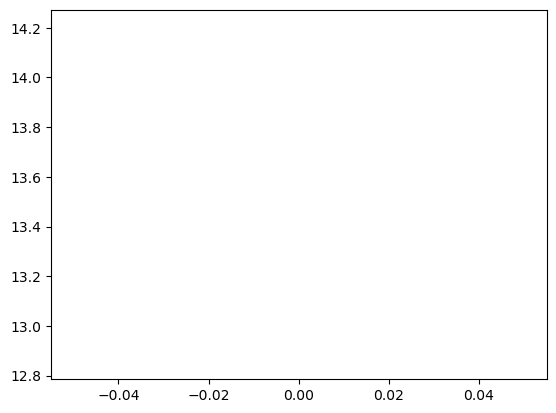

In [57]:
plt.plot(np.arange(means3.shape[0]),means3)

In [8]:
eventsSizes3,eventsSteps3,eventsTimes3,means3 = getData(1,1_000_000)
print(eventsSizes3.shape)

100%|██████████| 1/1 [28:39<00:00, 1719.58s/it]

torch.Size([37562])


In [26]:
eventsSizes3.cpu()[eventsSizes3.cpu().nonzero()].min()

tensor(0.0078)

In [27]:
np.logspace(np.log10(eventsSizes3.cpu()[eventsSizes3.cpu().nonzero()].min()),np.log10((eventsSizes3.cpu().max())),50)

array([7.81250088e-03, 9.52051800e-03, 1.16019524e-02, 1.41384428e-02,
       1.72294763e-02, 2.09962907e-02, 2.55866292e-02, 3.11805359e-02,
       3.79974170e-02, 4.63046467e-02, 5.64280541e-02, 6.87647033e-02,
       8.37984669e-02, 1.02119005e-01, 1.24444891e-01, 1.51651801e-01,
       1.84806853e-01, 2.25210467e-01, 2.74447368e-01, 3.34448744e-01,
       4.07567992e-01, 4.96673020e-01, 6.05258739e-01, 7.37584137e-01,
       8.98839330e-01, 1.09534913e+00, 1.33482111e+00, 1.62664793e+00,
       1.98227574e+00, 2.41565309e+00, 2.94377806e+00, 3.58736498e+00,
       4.37165684e+00, 5.32741542e+00, 6.49212783e+00, 7.91147686e+00,
       9.64113272e+00, 1.17489366e+01, 1.43175616e+01, 1.74477552e+01,
       2.12622911e+01, 2.59107843e+01, 3.15755598e+01, 3.84788034e+01,
       4.68912767e+01, 5.71429369e+01, 6.96358782e+01, 8.48601033e+01,
       1.03412743e+02, 1.26021474e+02])

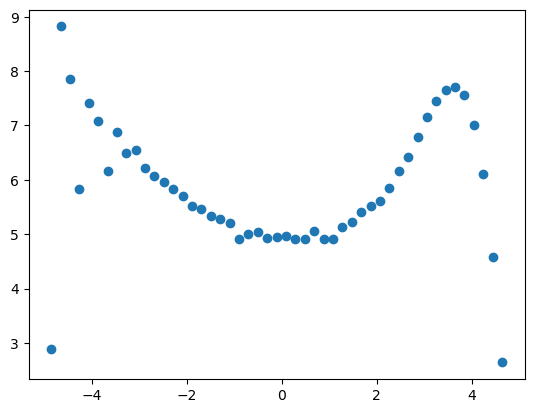

In [28]:
freq,size = np.histogram(eventsSizes3.cpu(),bins=np.logspace(np.log10(eventsSizes3.cpu()[eventsSizes3.cpu().nonzero()].min()),np.log10((eventsSizes3.cpu().max())),50))
plt.scatter(np.log(size[:-1]),np.log(freq))

/tmp/ipykernel_150552/3701693815.py:2: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(size[:-1]),np.log(freq))


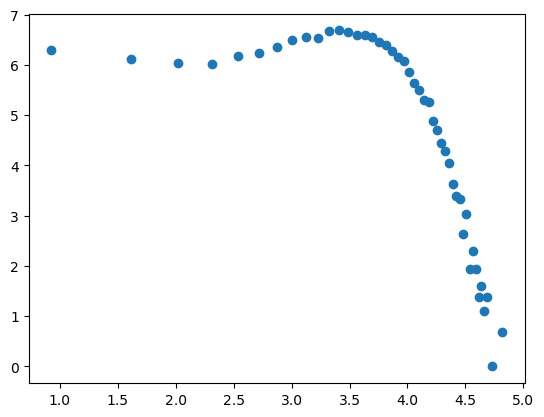

In [11]:
freq,size = np.histogram(eventsSizes3.cpu(),bins=50,density=False)
plt.scatter(np.log(size[:-1]),np.log(freq))

In [47]:
eventsSizes,eventsSteps,eventsTimes,means = getData2(100,225)
print(eventsSizes.shape)



100%|██████████| 100/100 [19:33<00:00, 11.73s/it]

torch.Size([49656])


In [46]:
eventsSizes,eventsSteps,eventsTimes,means = getData(500,225)
print(eventsSizes.shape)


  5%|▍         | 23/500 [05:45<1:59:32, 15.04s/it]


KeyboardInterrupt: 

In [42]:
eventsSizes.cpu().abs().nonzero().min(0)

torch.return_types.min(
values=tensor([0]),
indices=tensor([0]))

In [43]:
np.logspace(np.log10(eventsSizes.cpu()[eventsSizes.cpu() > 0 ].min()),np.log10((eventsSizes.cpu().max())),50)

array([7.93457184e-04, 1.14622276e-03, 1.65582548e-03, 2.39199405e-03,
       3.45545807e-03, 4.99173084e-03, 7.21101987e-03, 1.04169895e-02,
       1.50483110e-02, 2.17386860e-02, 3.14035556e-02, 4.53653594e-02,
       6.55344846e-02, 9.46706635e-02, 1.36760586e-01, 1.97563398e-01,
       2.85398719e-01, 4.12285016e-01, 5.95584085e-01, 8.60376653e-01,
       1.24289417e+00, 1.79547632e+00, 2.59373268e+00, 3.74688831e+00,
       5.41272895e+00, 7.81919083e+00, 1.12955490e+01, 1.63174721e+01,
       2.35721074e+01, 3.40521034e+01, 4.91914332e+01, 7.10616044e+01,
       1.02655103e+02, 1.48294852e+02, 2.14225718e+02, 3.09468991e+02,
       4.47056766e+02, 6.45815114e+02, 9.32940049e+02, 1.34771875e+03,
       1.94690519e+03, 2.81248578e+03, 4.06289751e+03, 5.86923367e+03,
       8.47865439e+03, 1.22482055e+04, 1.76936731e+04, 2.55601578e+04,
       3.69240273e+04, 5.33401946e+04])

/tmp/ipykernel_150552/4166423628.py:2: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(size[:-1]),np.log(freq))


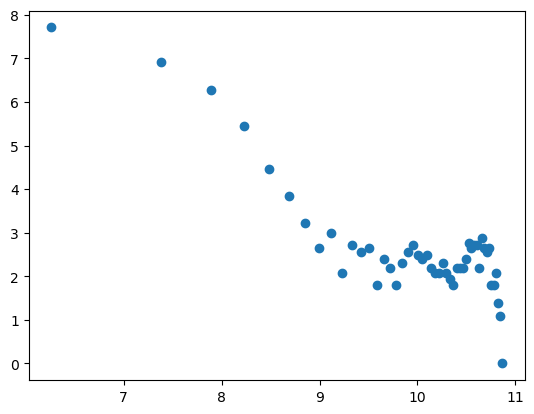

In [45]:
freq,size = np.histogram(eventsSizes.cpu(),bins=50)
plt.scatter(np.log(size[:-1]),np.log(freq))

In [52]:
eventsSizes.cpu().nonzero()

tensor([[    0],
        [    1],
        [    2],
        ...,
        [49653],
        [49654],
        [49655]])

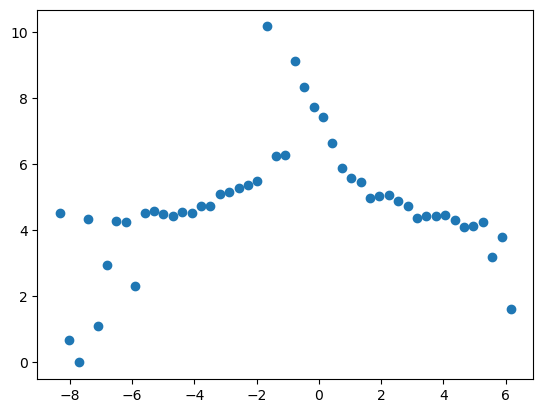

In [53]:
freq,size = np.histogram(eventsSizes.cpu(),bins=np.logspace(np.log10(eventsSizes.cpu()[eventsSizes.cpu().nonzero()].min()),np.log10((eventsSizes.cpu().max())),50))
plt.scatter(np.log(size[:-1]),np.log(freq))

/tmp/ipykernel_150552/2525369877.py:2: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(size[:-1]),np.log(freq))


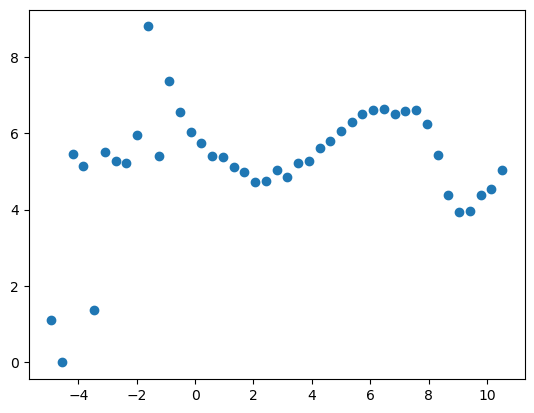

In [44]:
freq,size = np.histogram(eventsSizes.cpu(),bins=np.logspace(np.log10(eventsSizes.cpu()[eventsSizes.cpu() > 0].min()),np.log10((eventsSizes.cpu().max())),50))
plt.scatter(np.log(size[:-1]),np.log(freq))

In [28]:
eventsSizes2,eventsSteps2,eventsTimes2,means2 = getData2(100,100)
print(eventsSizes2.shape)

100%|██████████| 100/100 [03:10<00:00,  1.90s/it]

torch.Size([100000])


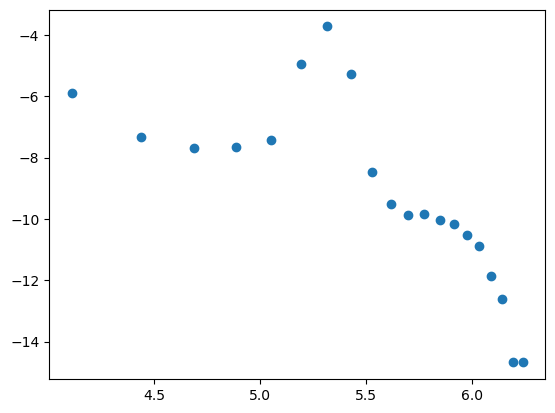

In [29]:
freq,size = np.histogram(eventsSizes2.cpu(),bins=20,density=True)
plt.scatter(np.log(size[:-1]),np.log(freq))

/tmp/ipykernel_60212/727942376.py:2: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(size[:-1]),np.log(freq))
/tmp/ipykernel_60212/727942376.py:2: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(size[:-1]),np.log(freq))


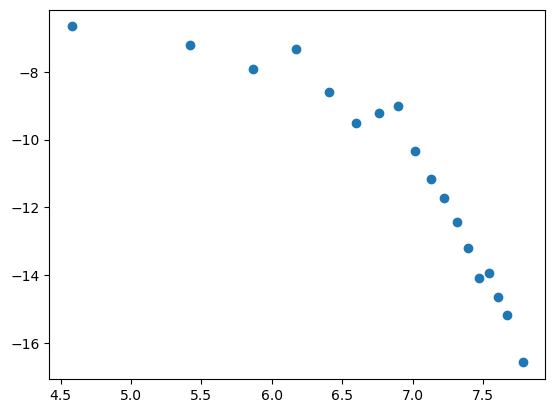

In [30]:

freq,size = np.histogram(eventsSizes.cpu(),bins=20,density=True)
plt.scatter(np.log(size[:-1]),np.log(freq))

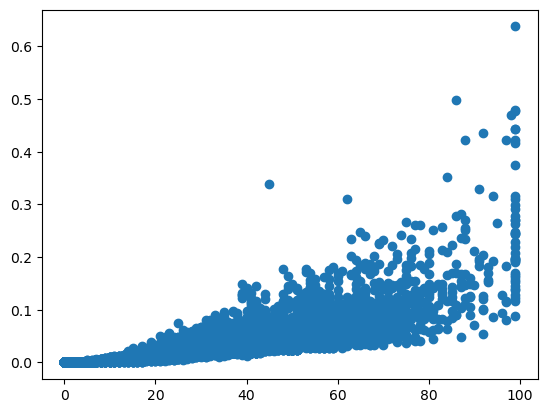

In [5]:
plt.scatter(eventsSteps1.cpu(),eventsSizes1.cpu() )

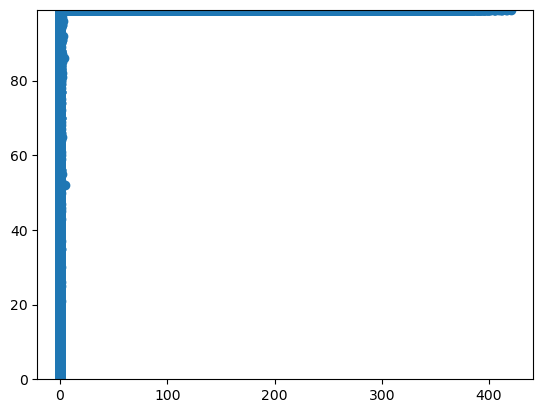

In [303]:
plt.ylim((0,99))
plt.scatter(eventsSizes.cpu(),eventsSteps.cpu() )

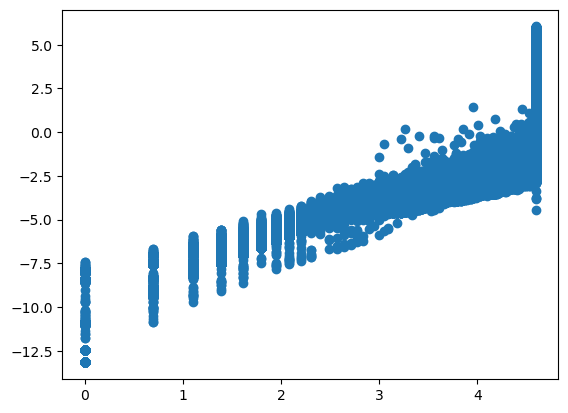

In [307]:
plt.scatter(torch.log(eventsSteps.cpu()),torch.log(eventsSizes.cpu() ))

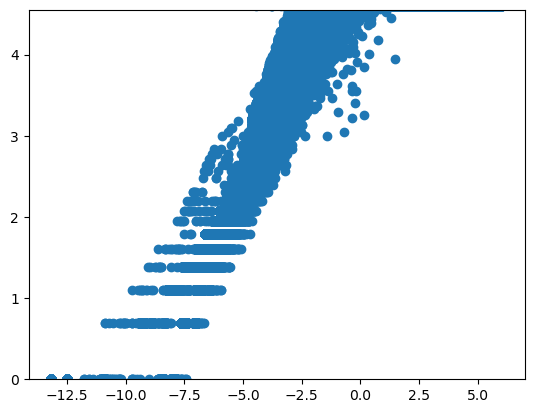

In [305]:
plt.ylim((0,np.log(95)))
plt.scatter(torch.log(eventsSizes.cpu()),torch.log(eventsSteps.cpu() ))

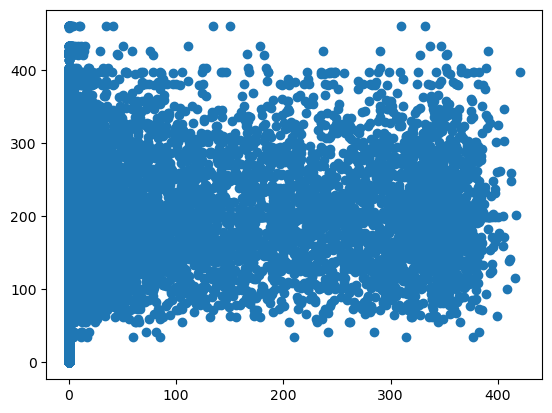

In [296]:
plt.scatter(eventsSizes.cpu(),eventsTimes.cpu() )

In [26]:
eventsSizes3.shape

torch.Size([244])

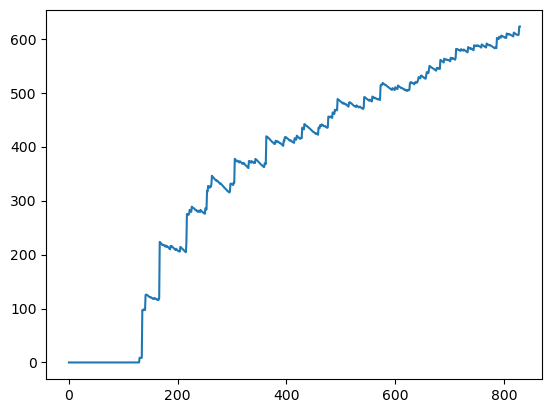

In [44]:
plt.plot(np.arange(eventsSizes3.shape[0]) , (eventsSizes3.cumsum(dim=0) / torch.arange(1, eventsSizes3.shape[0] + 1 , device = device)).cpu())

In [43]:
eventsSizes3,eventsSteps3,eventsTimes3,means3 = getData(1,1_000_000)


100%|██████████| 1/1 [24:26<00:00, 1466.90s/it]


In [3]:
eventsSizes1,eventsSteps1,eventsTimes1,means1 = getData(100,100)

100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


In [3]:
eventsSizes1,eventsSteps1,eventsTimes1,means1 = getData(100,100)
eventsSizes2,eventsSteps2,eventsTimes2,means2 = getData(1000,100)


100%|██████████| 1000/1000 [06:10<00:00,  2.70it/s]


In [6]:
torch.save(eventsSizes2, "eventsSizes2.pt")
torch.save(eventsSizes1, "eventsSizes1.pt")

100%|██████████| 100/100 [00:37<00:00,  2.66it/s]

torch.Size([239663])



/tmp/ipykernel_4033/2532018392.py:6: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(size[:-1]),np.log(freq))


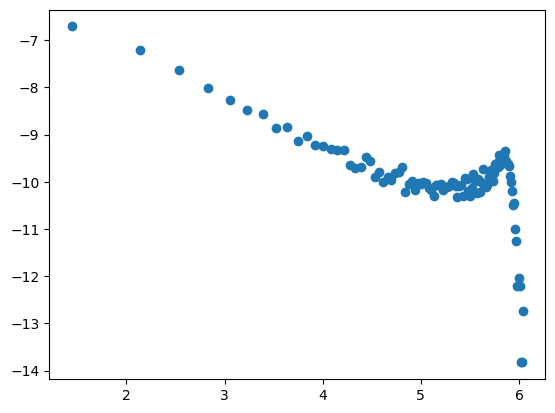

In [311]:

eventsSizes,eventsSteps,eventsTimes = getData(100,100)
print(eventsSizes.shape)

freq,size = np.histogram(eventsSizes.cpu(),bins=100,density=True)

plt.scatter(np.log(size[:-1]),np.log(freq))

/tmp/ipykernel_13131/1753121461.py:6: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(size[:-1]),np.log(freq))
/tmp/ipykernel_13131/1753121461.py:6: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(size[:-1]),np.log(freq))


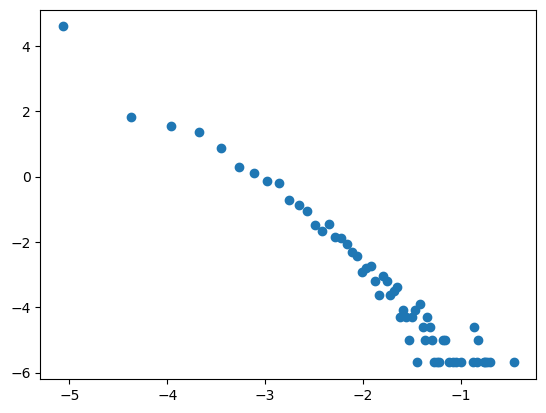

In [6]:
# eventsSizes,eventsSteps,eventsTimes = getData(1000,100)
# print(eventsSizes.shape)

freq,size = np.histogram(eventsSizes1.cpu(),bins=100,density=True)

plt.scatter(np.log(size[:-1]),np.log(freq))

100%|██████████| 1000/1000 [06:13<00:00,  2.68it/s]

torch.Size([1201020])



/tmp/ipykernel_4033/1716471032.py:6: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(size[:-1]),np.log(freq))


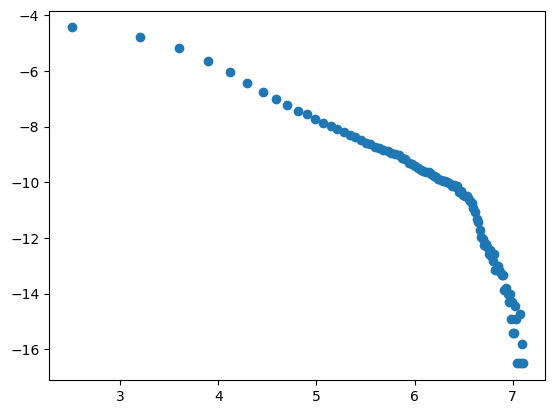

In [310]:
eventsSizes,eventsSteps,eventsTimes = getData(1000,100)
print(eventsSizes.shape)

freq,size = np.histogram(eventsSizes.cpu(),bins=100,density=True)

plt.scatter(np.log(size[:-1]),np.log(freq))

/tmp/ipykernel_4033/1837420553.py:7: RuntimeWarning: divide by zero encountered in log
  xs = np.log(size[:-1])[~np.isnan(np.log(size[:-1]))]
/tmp/ipykernel_4033/1837420553.py:8: RuntimeWarning: divide by zero encountered in log
  ys = np.log(freq)[~np.isnan(np.log(size[:-1]))]


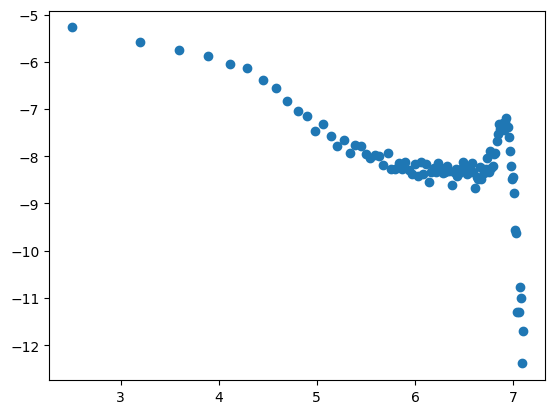

In [231]:
eventsSizes2 = eventsSizes
freq,size
freq,size = np.histogram(torch.abs(eventsSizes2).cpu(),bins=100)

freq = freq / np.sum(freq)

xs = np.log(size[:-1])[~np.isnan(np.log(size[:-1]))]
ys = np.log(freq)[~np.isnan(np.log(size[:-1]))]


plt.scatter(xs,ys)


/tmp/ipykernel_4033/2508933195.py:6: RuntimeWarning: invalid value encountered in log
  xs = np.log(size[:-1])[~np.isnan(np.log(size[:-1]))]
/tmp/ipykernel_4033/2508933195.py:7: RuntimeWarning: divide by zero encountered in log
  ys = np.log(freq)[~np.isnan(np.log(size[:-1]))]
/tmp/ipykernel_4033/2508933195.py:7: RuntimeWarning: invalid value encountered in log
  ys = np.log(freq)[~np.isnan(np.log(size[:-1]))]


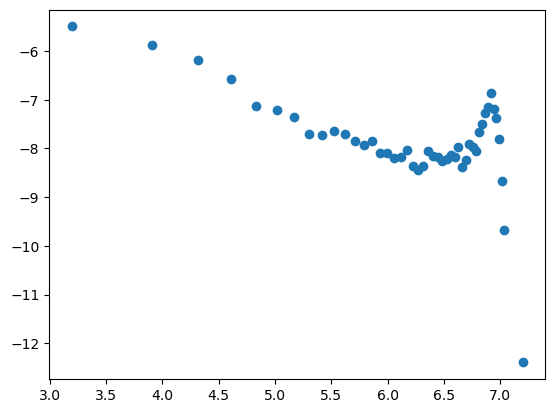

In [30]:
# eventsSizes2 = eventsSizes
freq,size = np.histogram(eventsSizes2.cpu(),bins=100)

freq = freq / np.sum(freq)

xs = np.log(size[:-1])[~np.isnan(np.log(size[:-1]))]
ys = np.log(freq)[~np.isnan(np.log(size[:-1]))]


plt.scatter(xs,ys)


In [56]:
torch.min(eventsSizes).item(),torch.max(eventsSizes).item()

(-4.406116485595703, 4.192386627197266)

In [47]:
eventsSizes.cpu().shape

torch.Size([488060])

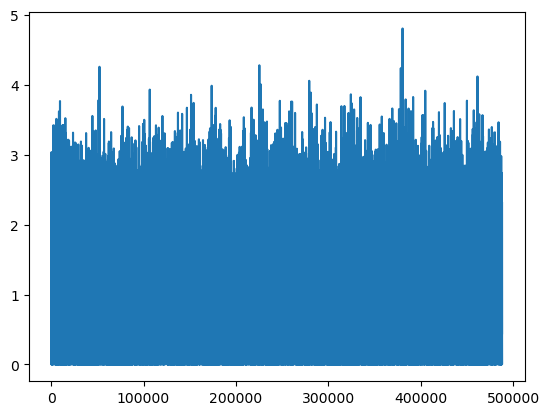

In [48]:
plt.plot(np.arange(488060),torch.abs(eventsSizes).cpu()[:488060])

/tmp/ipykernel_4033/4257429327.py:4: RuntimeWarning: invalid value encountered in log
  xs = np.log(size[:-1])[~np.isnan(np.log(size[:-1]))]
/tmp/ipykernel_4033/4257429327.py:5: RuntimeWarning: divide by zero encountered in log
  ys = np.log(freq)[~np.isnan(np.log(size[:-1]))]
/tmp/ipykernel_4033/4257429327.py:5: RuntimeWarning: invalid value encountered in log
  ys = np.log(freq)[~np.isnan(np.log(size[:-1]))]


Text(-1, 10, 'slope = -0.844, intercept = 10.549, rval = -0.976')

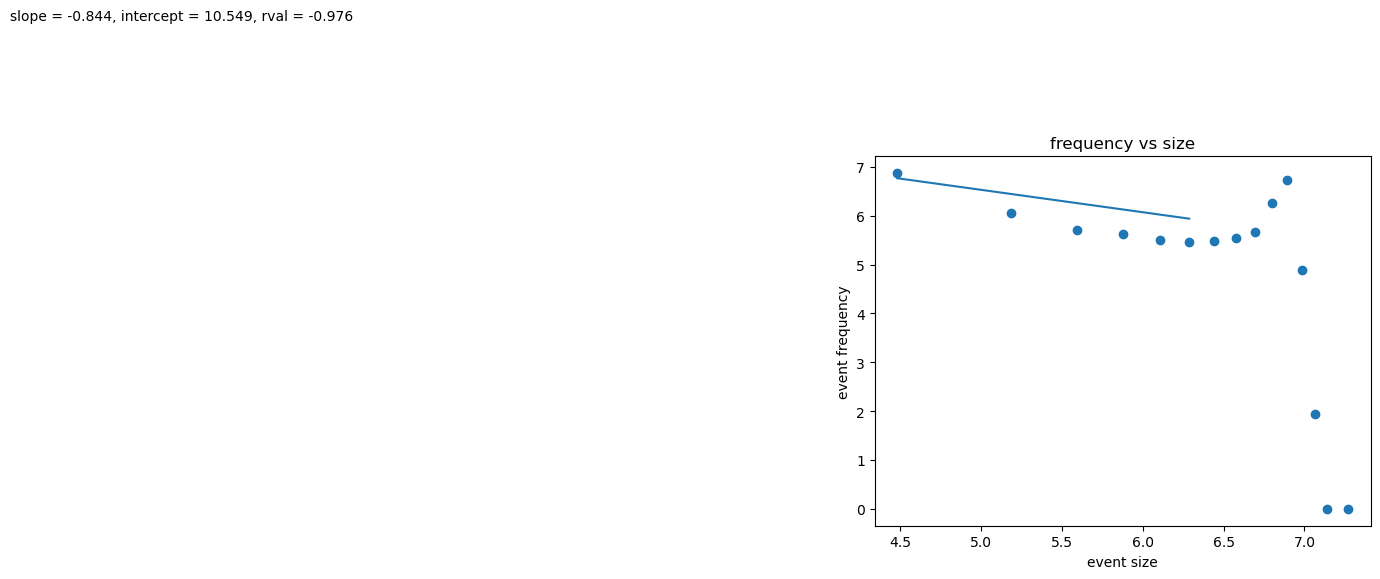

In [3]:
index = 5
freq,size = np.histogram(eventsSizes.cpu(),bins=30)

xs = np.log(size[:-1])[~np.isnan(np.log(size[:-1]))]
ys = np.log(freq)[~np.isnan(np.log(size[:-1]))]


slope , intercept, rvalue ,_,_= scipy.stats.linregress(xs[:index],ys[:index])
plt.title("frequency vs size")
plt.xlabel("event size")
plt.ylabel("event frequency")
plt.scatter(xs,ys)
plt.plot([xs[0],xs[index]],[intercept + slope.astype(np.float32)*xs[0], intercept + slope.astype(np.float32)*ys[index]])
plt.text(-1,10,s = f"slope = {np.round(slope,3)}, intercept = {np.round(intercept,3)}, rval = {np.round(rvalue,3)}")


In [317]:
arry  = np.array([4,2,4,3,8,3,2,3])
arrx = np.arange(8)